# Project

### Heart Disease Multi-Class Predictions

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import sklearn
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler

In [3]:
df1 = pd.read_csv('heart_disease_uci.csv')

In [4]:
df1.rename(columns = {"num": "disease"}, 
          inplace = True)

In [5]:
df1 = df1.drop(['id','dataset'],axis=1)

In [6]:
df1.head(6)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,disease
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,56,Male,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0


In [7]:
len(df1)

920

In [8]:
df1.isna().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
disease       0
dtype: int64

In [9]:
dfn = df1.drop(['ca','thal','slope'],axis=1)
dfn = dfn.dropna()

In [10]:
len(dfn)

740

In [11]:
dfn.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,disease
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1


In [12]:
print(dfn['sex'].unique())
print(dfn['cp'].unique())
print(dfn['fbs'].unique())
print(dfn['restecg'].unique())
print(dfn['exang'].unique())

['Male' 'Female']
['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
[True False]
['lv hypertrophy' 'normal' 'st-t abnormality']
[False True]


In [13]:
df2 = pd.get_dummies(dfn, columns = ['sex','cp','fbs','restecg','exang'])

In [14]:
df2.columns

Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'disease', 'sex_Female',
       'sex_Male', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal',
       'cp_typical angina', 'fbs_False', 'fbs_True', 'restecg_lv hypertrophy',
       'restecg_normal', 'restecg_st-t abnormality', 'exang_False',
       'exang_True'],
      dtype='object')

In [15]:
df2 = df2.drop(['sex_Female','cp_asymptomatic','fbs_False','restecg_normal','exang_False'], axis=1)

In [16]:
df2.rename(columns = {'sex_Male':'male', 'fbs_True':'fbs','exang_True':'exang'}, inplace = True)

In [17]:
df2.columns

Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'disease', 'male',
       'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs',
       'restecg_lv hypertrophy', 'restecg_st-t abnormality', 'exang'],
      dtype='object')

In [18]:
df2 = df2[['age', 'male', 'trestbps', 'chol', 'thalch', 'oldpeak',
       'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs',
       'restecg_lv hypertrophy', 'restecg_st-t abnormality', 'exang', 'disease']]

In [19]:
def binary(row):
    if row['disease'] == 0:
        return 0
    else:
        return 1

In [20]:
df2['disease_binary'] = df2.apply(binary, axis=1)

In [21]:
df2.head(5)

,age,male,trestbps,chol,thalch,oldpeak,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs,restecg_lv hypertrophy,restecg_st-t abnormality,exang,disease,disease_binary
0,63,1,145.0,233.0,150.0,2.3,0,0,1,1,1,0,0,0,0
1,67,1,160.0,286.0,108.0,1.5,0,0,0,0,1,0,1,2,1
2,67,1,120.0,229.0,129.0,2.6,0,0,0,0,1,0,1,1,1
3,37,1,130.0,250.0,187.0,3.5,0,1,0,0,0,0,0,0,0
4,41,0,130.0,204.0,172.0,1.4,1,0,0,0,1,0,0,0,0


<AxesSubplot:xlabel='disease', ylabel='count'>

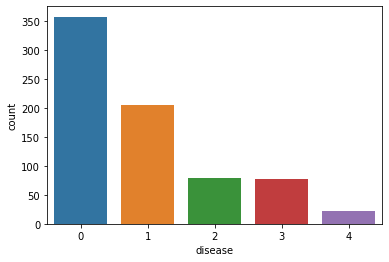

In [22]:
sns.countplot(x="disease", data=df2)

<AxesSubplot:xlabel='disease_binary', ylabel='count'>

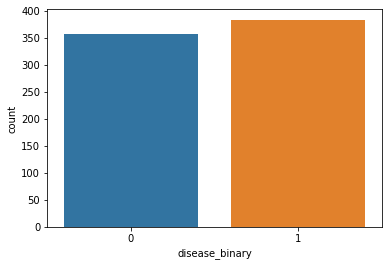

In [23]:
sns.countplot(x="disease_binary", data=df2)

In [24]:
bins = [0, 30, 40, 50, 60, 70, 80]
df2['age_binned'] = pd.cut(df2['age'], bins)

<AxesSubplot:xlabel='age_binned', ylabel='count'>

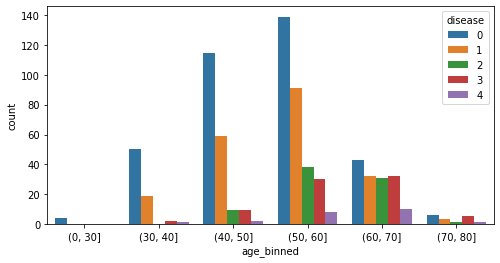

In [25]:
plt.figure(figsize=(8, 4))
sns.countplot(x="age_binned", hue="disease", data=df2)

<AxesSubplot:xlabel='age_binned', ylabel='percentage'>

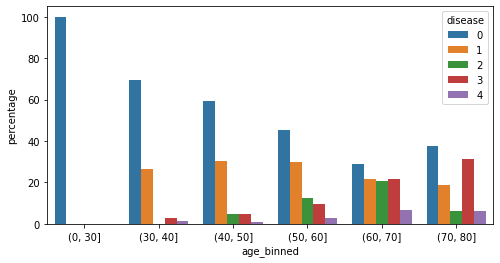

In [26]:
norm = (df2.groupby(['age_binned'])['disease']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('age_binned'))
plt.figure(figsize=(8, 4))
sns.barplot(x="age_binned", y="percentage", hue="disease", data=norm)

<AxesSubplot:xlabel='male', ylabel='count'>

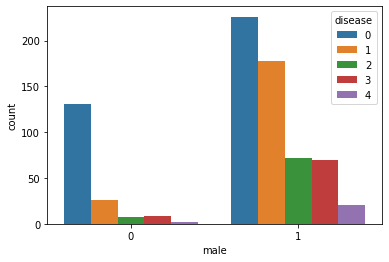

In [27]:
sns.countplot(x="male", hue="disease", data=df2)

<AxesSubplot:xlabel='fbs', ylabel='count'>

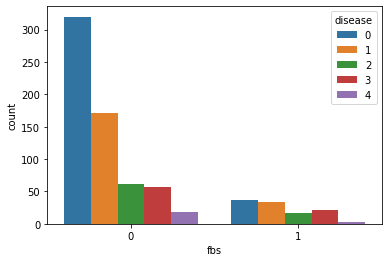

In [28]:
sns.countplot(x="fbs", hue="disease", data=df2)

<AxesSubplot:xlabel='fbs', ylabel='percentage'>

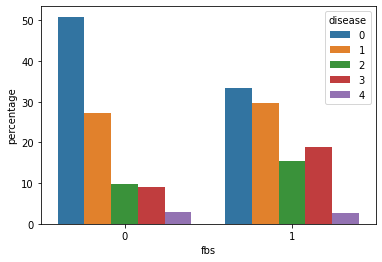

In [29]:
norm = (df2.groupby(['fbs'])['disease']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('fbs'))
sns.barplot(x="fbs", y="percentage", hue="disease", data=norm)

In [30]:
def plot_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [31]:
df = df2.drop(['age_binned'],axis=1)
df = df.reset_index(drop=True)
df

,age,male,trestbps,chol,thalch,oldpeak,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs,restecg_lv hypertrophy,restecg_st-t abnormality,exang,disease,disease_binary
0,63,1,145.0,233.0,150.0,2.3,0,0,1,1,1,0,0,0,0
1,67,1,160.0,286.0,108.0,1.5,0,0,0,0,1,0,1,2,1
2,67,1,120.0,229.0,129.0,2.6,0,0,0,0,1,0,1,1,1
3,37,1,130.0,250.0,187.0,3.5,0,1,0,0,0,0,0,0,0
4,41,0,130.0,204.0,172.0,1.4,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,62,1,158.0,170.0,138.0,0.0,0,0,0,0,0,1,1,1,1
736,46,1,134.0,310.0,126.0,0.0,0,0,0,0,0,0,0,2,1
737,54,0,127.0,333.0,154.0,0.0,0,0,0,1,0,1,0,1,1
738,55,1,122.0,223.0,100.0,0.0,0,0,0,1,0,1,0,2,1


In [32]:
df.columns

Index(['age', 'male', 'trestbps', 'chol', 'thalch', 'oldpeak',
       'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs',
       'restecg_lv hypertrophy', 'restecg_st-t abnormality', 'exang',
       'disease', 'disease_binary'],
      dtype='object')

In [33]:
x = df[['age', 'male', 'trestbps', 'chol', 'thalch', 'oldpeak',
       'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs',
       'restecg_lv hypertrophy', 'restecg_st-t abnormality', 'exang']]
yb = df['disease_binary']
y = df['disease']

In [34]:
xb_train, xb_test, yb_train, yb_test = train_test_split(x,yb,test_size=0.2,random_state = 0)

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state = 0)

In [36]:
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(x, y)
xs_train, xs_test, ys_train, ys_test = train_test_split(x_sm,y_sm,test_size=0.2,random_state = 0)
xb_sm, yb_sm = sm.fit_resample(x, yb)
xbs_train, xbs_test, ybs_train, ybs_test = train_test_split(xb_sm,yb_sm,test_size=0.2,random_state = 0)

In [37]:
pipe = Pipeline([('preprocessing', PolynomialFeatures()),
                 ('preprocessing2', StandardScaler()),
                  ('classifier', MLPClassifier()) ])

param_grid = [{'classifier': [DecisionTreeClassifier(random_state=0)], 
     'preprocessing__degree' : [1,2,3],
     'preprocessing2': [StandardScaler(), RobustScaler()]},
    {'classifier': [RandomForestClassifier(n_jobs=-1, random_state=0)], 
     'preprocessing__degree' : [1,2,3],
     'preprocessing2': [StandardScaler(), RobustScaler()],
     'classifier__n_estimators': [100, 500, 1000]},
    {'classifier': [MLPClassifier(max_iter=1100, random_state=0)], 
     'preprocessing__degree' : [1,2,3],
     'preprocessing2': [StandardScaler(), RobustScaler()], 
     'classifier__alpha': [0.0001, 0.001, 0.01, 0.1]},
    {'classifier': [KNeighborsClassifier()], 
     'preprocessing__degree' : [1,2,3],
     'preprocessing2': [StandardScaler(), RobustScaler()], 
     'classifier__n_neighbors': [5, 10]}]

In [38]:
# grid = GridSearchCV(pipe, param_grid, scoring = 'accuracy', cv=5)
# grid.fit(xs_train, ys_train)

In [39]:
# df_grid = pd.DataFrame(grid.cv_results_)
# df_grid = df_grid.sort_values(by=['rank_test_score']).set_index('rank_test_score')
# df_grid.head(5)

In [40]:
# grid.best_params_

The previous pipeline took a long time to run, so the following pipelines use the resultant best parameters.

In [41]:
pipe = Pipeline([('preprocessing', PolynomialFeatures()),
                 ('preprocessing2', StandardScaler()),
                  ('classifier', RandomForestClassifier()) ])

param_grid = [{'classifier': [RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)],
 'preprocessing__degree': [1],
 'preprocessing2': [RobustScaler()],
 'classifier__n_estimators': [1000]}]

In [42]:
gridb = GridSearchCV(pipe, param_grid, scoring = 'accuracy', cv=5)
gridb.fit(xbs_train, ybs_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', PolynomialFeatures()),
                                       ('preprocessing2', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier': [RandomForestClassifier(n_estimators=1000,
                                                                n_jobs=-1,
                                                                random_state=0)],
                          'classifier__n_estimators': [1000],
                          'preprocessing2': [RobustScaler()],
                          'preprocessing__degree': [1]}],
             scoring='accuracy')

In [43]:
gridb.score(xb_train, yb_train)

0.9628378378378378

In [44]:
gridb.score(xb_test, yb_test)

0.9391891891891891

In [45]:
yb_pred = gridb.predict(xb_test)

In [46]:
confb = confusion_matrix(yb_test.values, yb_pred)
confb

array([[56,  7],
       [ 2, 83]], dtype=int64)

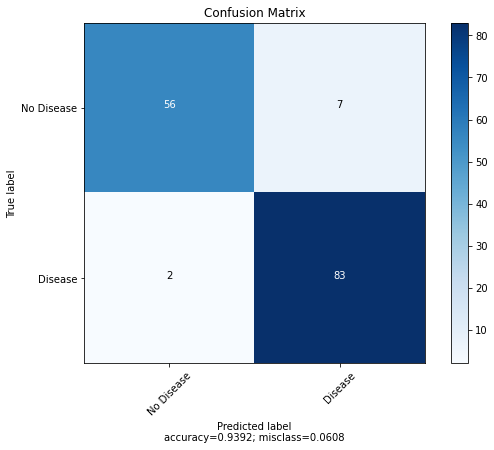

In [47]:
plot_matrix(cm = confb, target_names = ['No Disease','Disease'], normalize = False)

In [48]:
pipe = Pipeline([('preprocessing', PolynomialFeatures()),
                 ('preprocessing2', StandardScaler()),
                  ('classifier', RandomForestClassifier()) ])

param_grid = [{'classifier': [RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)],
 'preprocessing__degree': [1],
 'preprocessing2': [RobustScaler()],
 'classifier__n_estimators': [1000]}]

In [49]:
grid = GridSearchCV(pipe, param_grid, scoring = 'accuracy', cv=5)
grid.fit(xs_train, ys_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', PolynomialFeatures()),
                                       ('preprocessing2', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier': [RandomForestClassifier(n_estimators=1000,
                                                                n_jobs=-1,
                                                                random_state=0)],
                          'classifier__n_estimators': [1000],
                          'preprocessing2': [RobustScaler()],
                          'preprocessing__degree': [1]}],
             scoring='accuracy')

In [50]:
grid.score(x_train, y_train)

0.9375

In [51]:
grid.score(x_test, y_test)

0.9256756756756757

In [52]:
y_pred = grid.predict(x_test)

In [53]:
conf = confusion_matrix(y_test.values, y_pred)
conf

array([[62,  0,  0,  0,  1],
       [ 2, 35,  2,  3,  0],
       [ 1,  2, 21,  0,  0],
       [ 0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  7]], dtype=int64)

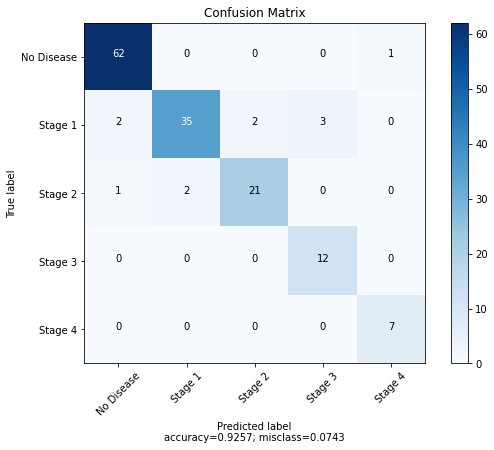

In [54]:
plot_matrix(cm = conf, target_names = ['No Disease','Stage 1','Stage 2','Stage 3','Stage 4'], normalize = False)

In [55]:
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.954     0.984     0.969        63
           1      0.946     0.833     0.886        42
           2      0.913     0.875     0.894        24
           3      0.800     1.000     0.889        12
           4      0.875     1.000     0.933         7

    accuracy                          0.926       148
   macro avg      0.898     0.938     0.914       148
weighted avg      0.929     0.926     0.925       148

